In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from rdkit import Chem
from rdkit.Chem import AllChem
from tdc import Oracle

In [33]:
# Load data and Oracle
oracle = Oracle(name='DRD2')
training_data = pd.read_csv("../data/drd2_final_train_small.csv")
testing_data = pd.read_csv("../data/drd2_final_test_small.csv")
smiles_train = training_data['smiles'].tolist()
smiles_test = testing_data['smiles'].tolist()
label_proba_train = [oracle(smiles) for smiles in smiles_train]
label_proba_test = [oracle(smiles) for smiles in smiles_test]
print(f"Training data len: {len(smiles_train)}")
print(f"Testing data len: {len(smiles_test)}")

Found local copy...


Training data len: 200
Testing data len: 200


### Computing morgan fingerprints

In [34]:
def compute_fingerprints(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    else:
        return np.zeros((2048,), dtype=int)

features_train = torch.tensor([compute_fingerprints(smiles) for smiles in smiles_train])
features_test = torch.tensor([compute_fingerprints(smiles) for smiles in smiles_test])
label_proba_train = torch.tensor(label_proba_train)
label_proba_test = torch.tensor(label_proba_test)
label_binary_train = torch.tensor(training_data["label"].to_numpy())
label_binary_test = torch.tensor(testing_data["label"].to_numpy())

print("features_train shape: ", features_train.shape)
print("label_proba_train shape: ", label_proba_train.shape)
print("label_binary_train shape: ", label_binary_train.shape)

print("features_test shape: ", features_test.shape)
print("label_proba_test shape: ", label_proba_test.shape)
print("label_binary_test shape: ", label_binary_test.shape)

features_train shape:  torch.Size([200, 2048])
label_proba_train shape:  torch.Size([200])
label_binary_train shape:  torch.Size([200])
features_test shape:  torch.Size([200, 2048])
label_proba_test shape:  torch.Size([200])
label_binary_test shape:  torch.Size([200])


### Generate pairs and labels

In [35]:
from itertools import combinations
import numpy as np
# Generate all unrepeated combinations of 3 out of len(new_queried_smiles)
num_sets = 1000
smiles_len, features_dim = 1000, 2048
comb = combinations(range(smiles_len), 3)

rng = np.random.default_rng()

nCr = lambda n, r: np.math.factorial(n) / (np.math.factorial(r) * np.math.factorial(n - r))
num_comb = int(nCr(smiles_len, 3))
chosen_indices = rng.choice(num_comb, num_sets, replace=False)
# print(num_comb)
# print(chosen_indices)

In [36]:
def generate_pairs_label(features, label_proba, label_binary, smiles_list, num_sets = 1000):
    
    from itertools import combinations

    # Generate all unrepeated combinations of 3 out of len(new_queried_smiles)
    
    smiles_len, features_dim = features.shape

    comb = combinations(range(smiles_len), 3)

    rng = np.random.default_rng()

    nCr = lambda n, r: np.math.factorial(n) / (np.math.factorial(r) * np.math.factorial(n - r))
    num_comb = int(nCr(smiles_len, 3))
    chosen_indices = rng.choice(num_comb, num_sets, replace=False)
    chosen_indices.sort()  # Sort indices to optimize the iteration process

    features_1 = np.zeros((num_sets, features_dim), dtype = np.float32)
    features_2 = np.zeros((num_sets, features_dim), dtype = np.float32)
    features_3 = np.zeros((num_sets, features_dim), dtype = np.float32)

    label_1_proba = []
    label_1_binary = []
    label_1_softmax = []
    label_1_rank = []
    label_2_proba = []
    label_2_binary = []
    label_2_softmax = []
    label_2_rank = []
    label_3_proba = []
    label_3_binary = []
    label_3_softmax = []
    label_3_rank = []
    smiles_1 = []
    smiles_2 = []
    smiles_3 = []

    current_index = 0  # Track the index of combinations
    output_index = 0  # Track the index of output arrays

    for i, (idx1, idx2, idx3) in enumerate(comb):
        if current_index == chosen_indices[output_index]:
            features_1[output_index, :] = features[idx1, :]
            features_2[output_index, :] = features[idx2, :]
            features_3[output_index, :] = features[idx3, :]

            smiles_1.append(smiles_list[idx1])
            smiles_2.append(smiles_list[idx2])
            smiles_3.append(smiles_list[idx3])

            label_1_proba.append(label_proba[idx1])
            label_2_proba.append(label_proba[idx2])
            label_3_proba.append(label_proba[idx3])

            label_1_binary.append(label_binary[idx1])
            label_2_binary.append(label_binary[idx2])
            label_3_binary.append(label_binary[idx3])

            # convert to float
            proba_list = [label_proba[idx1], label_proba[idx2], label_proba[idx3]]
            proba_softmax = nn.Softmax(dim=0)(torch.tensor(proba_list))

            label_1_softmax.append(proba_softmax[0])
            label_2_softmax.append(proba_softmax[1])
            label_3_softmax.append(proba_softmax[2])

            # Now we need to rank them
            # Rank 1 has lowest value, Rank 3 has highest value
            ranks = np.argsort(np.argsort(proba_softmax))
            label_1_rank.append(ranks[0])
            label_2_rank.append(ranks[1])
            label_3_rank.append(ranks[2])
            
            output_index += 1
            if output_index == num_sets:  # Stop if we've collected enough sets
                break
        current_index += 1

    # Convert to numpy
    label_1_proba = np.array(label_1_proba)
    label_1_binary = np.array(label_1_binary)
    label_1_softmax = np.array(label_1_softmax)
    label_1_rank = np.array(label_1_rank)
    label_2_proba = np.array(label_2_proba)
    label_2_binary = np.array(label_2_binary)
    label_2_softmax = np.array(label_2_softmax)
    label_2_rank = np.array(label_2_rank)
    label_3_proba = np.array(label_3_proba)
    label_3_binary = np.array(label_3_binary)
    label_3_softmax = np.array(label_3_softmax)
    label_3_rank = np.array(label_3_rank)

    return features_1, features_2, features_3,\
        label_1_proba, label_1_binary, label_1_softmax, label_1_rank,\
        label_2_proba, label_2_binary, label_2_softmax, label_2_rank,\
        label_3_proba, label_3_binary, label_3_softmax, label_3_rank,\
        smiles_1, smiles_2, smiles_3

features_1_train, features_2_train, features_3_train,\
label_1_proba_train, label_1_binary_train, label_1_softmax_train, label_1_rank_train,\
label_2_proba_train, label_2_binary_train, label_2_softmax_train, label_2_rank_train,\
label_3_proba_train, label_3_binary_train, label_3_softmax_train, label_3_rank_train,\
smiles_1_train, smiles_2_train, smiles_3_train = generate_pairs_label(features_train, label_proba_train, label_binary_train, smiles_train, num_sets = len(smiles_train))

features_1_test, features_2_test, features_3_test,\
label_1_proba_test, label_1_binary_test, label_1_softmax_test, label_1_rank_test,\
label_2_proba_test, label_2_binary_test, label_2_softmax_test, label_2_rank_test,\
label_3_proba_test, label_3_binary_test, label_3_softmax_test, label_3_rank_test,\
smiles_1_test, smiles_2_test, smiles_3_test = generate_pairs_label(features_test, label_proba_test, label_binary_test, smiles_test, num_sets = len(smiles_test))

In [37]:
print(features_1_train.shape, features_1_test.shape)
print(features_2_train.shape, features_2_test.shape)
print(features_3_train.shape, features_3_test.shape)
print(label_1_proba_train.shape, label_1_proba_test.shape)
print(label_1_binary_train.shape, label_1_binary_test.shape)
print(label_1_softmax_train.shape, label_1_softmax_test.shape)
print(label_1_rank_train.shape, label_1_rank_test.shape)
print(label_2_proba_train.shape, label_2_proba_test.shape)
print(label_2_binary_train.shape, label_2_binary_test.shape)
print(label_2_softmax_train.shape, label_2_softmax_test.shape)
print(label_2_rank_train.shape, label_2_rank_test.shape)
print(label_3_proba_train.shape, label_3_proba_test.shape)
print(label_3_binary_train.shape, label_3_binary_test.shape)
print(label_3_softmax_train.shape, label_3_softmax_test.shape)
print(label_3_rank_train.shape, label_3_rank_test.shape)

(200, 2048) (200, 2048)
(200, 2048) (200, 2048)
(200, 2048) (200, 2048)
(200,) (200,)
(200,) (200,)
(200,) (200,)
(200,) (200,)
(200,) (200,)
(200,) (200,)
(200,) (200,)
(200,) (200,)
(200,) (200,)
(200,) (200,)
(200,) (200,)
(200,) (200,)


In [38]:
# Now we need to save them 

small_drd2_training_data = pd.DataFrame()
small_drd2_training_data['smiles_1'] = smiles_1_train
small_drd2_training_data['smiles_2'] = smiles_2_train
small_drd2_training_data['smiles_3'] = smiles_3_train
small_drd2_training_data['label_1_proba'] = label_1_proba_train
small_drd2_training_data['label_2_proba'] = label_2_proba_train
small_drd2_training_data['label_3_proba'] = label_3_proba_train
small_drd2_training_data['label_1_binary'] = label_1_binary_train
small_drd2_training_data['label_2_binary'] = label_2_binary_train
small_drd2_training_data['label_3_binary'] = label_3_binary_train
small_drd2_training_data['label_1_softmax'] = label_1_softmax_train
small_drd2_training_data['label_2_softmax'] = label_2_softmax_train
small_drd2_training_data['label_3_softmax'] = label_3_softmax_train
small_drd2_training_data['label_1_rank'] = label_1_rank_train
small_drd2_training_data['label_2_rank'] = label_2_rank_train
small_drd2_training_data['label_3_rank'] = label_3_rank_train

small_drd2_training_data.to_csv("small_drd2_training_data.csv", index=False)

small_drd2_testing_data = pd.DataFrame()
small_drd2_testing_data['smiles_1'] = smiles_1_test
small_drd2_testing_data['smiles_2'] = smiles_2_test
small_drd2_testing_data['smiles_3'] = smiles_3_test
small_drd2_testing_data['label_1_proba'] = label_1_proba_test
small_drd2_testing_data['label_2_proba'] = label_2_proba_test
small_drd2_testing_data['label_3_proba'] = label_3_proba_test
small_drd2_testing_data['label_1_binary'] = label_1_binary_test
small_drd2_testing_data['label_2_binary'] = label_2_binary_test
small_drd2_testing_data['label_3_binary'] = label_3_binary_test
small_drd2_testing_data['label_1_softmax'] = label_1_softmax_test
small_drd2_testing_data['label_2_softmax'] = label_2_softmax_test
small_drd2_testing_data['label_3_softmax'] = label_3_softmax_test
small_drd2_testing_data['label_1_rank'] = label_1_rank_test
small_drd2_testing_data['label_2_rank'] = label_2_rank_test
small_drd2_testing_data['label_3_rank'] = label_3_rank_test

small_drd2_testing_data.to_csv("small_drd2_testing_data.csv", index=False)

### Use proba softmax to train. Probably a correct approach

In [39]:
from rank_listnet import RankListNetModel
    
# Training the model
model = RankListNetModel(feature_dim=2048)

# When using Binary Cross-Entropy Loss (BCELoss) in neural networks, the input expected by the 
# loss function is a list of probabilities, not binary values (0 or 1)

# Define the loss function
criterion = nn.KLDivLoss(reduction='batchmean')

# Correct Usage of JSDLoss
# Model Outputs: Should be log-probabilities.
# True label: Should be probabilities.

optimizer = optim.Adam(model.parameters(), lr=0.000001)

# Create torch data loader

from torch.utils.data import TensorDataset, DataLoader

# Assuming X_train and y_train are numpy arrays, convert them to PyTorch tensors
features_1_train_tensor = torch.tensor(features_1_train).float()  
features_2_train_tensor = torch.tensor(features_2_train).float()
features_3_train_tensor = torch.tensor(features_3_train).float()
label_1_softmax_train_tensor = torch.tensor(label_1_softmax_train).float()
label_2_softmax_train_tensor = torch.tensor(label_2_softmax_train).float()
label_3_softmax_train_tensor = torch.tensor(label_3_softmax_train).float()

features_1_test_tensor = torch.tensor(features_1_test).float()
features_2_test_tensor = torch.tensor(features_2_test).float()
features_3_test_tensor = torch.tensor(features_3_test).float()
label_1_softmax_test_tensor = torch.tensor(label_1_softmax_test).float()
label_2_softmax_test_tensor = torch.tensor(label_2_softmax_test).float()
label_3_softmax_test_tensor = torch.tensor(label_3_softmax_test).float()

# Create a TensorDataset
train_dataset = TensorDataset(features_1_train_tensor, features_2_train_tensor, 
                              features_3_train_tensor, label_1_softmax_train_tensor,
                                label_2_softmax_train_tensor, label_3_softmax_train_tensor)
              
test_dataset = TensorDataset(features_1_test_tensor, features_2_test_tensor,
                                features_3_test_tensor, label_1_softmax_test_tensor,
                                label_2_softmax_test_tensor, label_3_softmax_test_tensor)

# Create a DataLoader
batch_size = 32  # You can adjust the batch size as needed
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

def train(model, train_loader, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for features_1, features_2, features_3, label_1_softmax, label_2_softmax, label_3_softmax in train_loader:
            optimizer.zero_grad()
            ranking_scores = model(features_1, features_2, features_3) # softmax scores
            true_label = torch.stack([label_1_softmax, label_2_softmax, label_3_softmax], dim=1)
            
            # Taking log 
            ranking_scores = torch.log(ranking_scores + 1e-12)

            loss = criterion(ranking_scores, true_label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}, Loss: {total_loss / len(features_1)}')

train(model, train_loader)

# save state dict
torch.save(model.state_dict(), "rank_listnet_model.pth")

print("Model trained and saved")

Epoch 5, Loss: 0.05683773336932063
Model trained and saved


### Perform prediction on the testing dataset

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

def compute_metrics(label, predictions):
    """
    Compute classification metrics: accuracy, precision, recall, F1 score, and MCC.
    
    Args:
    label (list[int]): True binary label.
    predictions (list[int]): Predicted binary label.

    Returns:
    dict: A dictionary containing the computed metrics.
    """
    accuracy = accuracy_score(label, predictions)
    precision = precision_score(label, predictions)
    recall = recall_score(label, predictions)
    f1 = f1_score(label, predictions)
    mcc = matthews_corrcoef(label, predictions)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'F1': f1,
        'MCC': mcc
    }

### Prediction using the feedback

In [41]:
# Initialize the model
model = RankListNetModel(feature_dim=2048)

# Load the state dict
model.load_state_dict(torch.load("rank_listnet_model.pth"))

from scripts.predict import predict_feedback_from_model

batch_pred = 50000
print("Expected number of batches")
print(int(np.ceil(nCr(len(smiles_test), 3) / batch_pred)))

pred_label_feedback_test = predict_feedback_from_model(feedback_type = "ranking", 
                                                 feedback_model = model, 
                                                 smiles=smiles_test, batch_pred=batch_pred)


pred_label_binary_test = (torch.tensor(pred_label_feedback_test) > 0.5).int().tolist()

metrics = compute_metrics(label_binary_test, pred_label_binary_test)

assert all([0 <= x <= 1 for x in pred_label_feedback_test]), "Feedback score should be between 0 and 1"

print("\nAccuracy:", metrics['accuracy'])
print("Precision:", metrics['precision'])
print("Recall:", metrics['recall'])
print("F1:", metrics['F1'])
print("MCC:", metrics['MCC'])

Expected number of batches
27
B1 processed | B2 processed | B3 processed | B4 processed | B5 processed | B6 processed | B7 processed | B8 processed | B9 processed | B10 processed | B11 processed | B12 processed | B13 processed | B14 processed | B15 processed | B16 processed | B17 processed | B18 processed | B19 processed | B20 processed | B21 processed | B22 processed | B23 processed | B24 processed | B25 processed | B26 processed | B27 processed | 
Accuracy: 0.5
Precision: 0.5
Recall: 0.49
F1: 0.494949494949495
MCC: 0.0


### Plot the roc curve using the feedback

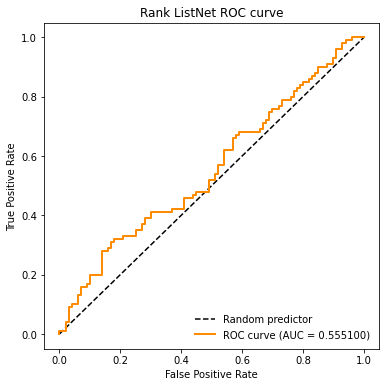

In [42]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(label_binary_test, pred_label_feedback_test, pos_label=1)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))

# draw a diagonal line
plt.plot([0, 1], [0, 1], 'k--', label="Random predictor")

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.6f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Rank ListNet ROC curve')

plt.legend(loc="lower right", frameon=False)

### Prediction using the label probability

In [43]:
# Initialize the model
model = RankListNetModel(feature_dim=2048)

# Load the state dict
model.load_state_dict(torch.load("rank_listnet_model.pth"))

from scripts.predict import predict_proba_from_model

pred_label_proba_test = predict_proba_from_model(feedback_type = "comparing", 
                                                 feedback_model = model, 
                                                 smiles=smiles_test)


pred_label_binary_test = (torch.tensor(pred_label_proba_test) > 0.5).int().tolist()

metrics = compute_metrics(label_binary_test, pred_label_binary_test)

assert all([0 <= x <= 1 for x in pred_label_proba_test]), "Probability should be between 0 and 1"

print("\nAccuracy:", metrics['accuracy'])
print("Precision:", metrics['precision'])
print("Recall:", metrics['recall'])
print("F1:", metrics['F1'])
print("MCC:", metrics['MCC'])


Accuracy: 0.5
Precision: 0.5
Recall: 1.0
F1: 0.6666666666666666
MCC: 0.0


### Plot the roc curve using the label probability

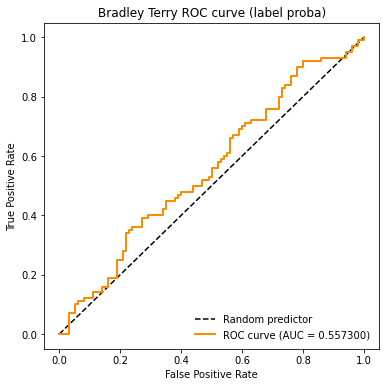

In [44]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(label_binary_test, pred_label_proba_test, pos_label=1)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))

# draw a diagonal line
plt.plot([0, 1], [0, 1], 'k--', label="Random predictor")

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.6f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Rank ListNet ROC curve (label proba)')

plt.legend(loc="lower right", frameon=False)

#### The model performs weakly, which means that we can now use this model as a human component for HITL. Ideally, the initial model should be no better than random guess. Additionally, the AUC of both feedback and label probability are nearly similar, which means that the feedback is valid for REINVENT